# HoxHunt Summer Hunters 2021 - Data - Home assignment


<img src="http://hunters.hoxhunt.com/public/hero.svg" width="800">

## Assignment

In this assignment you as a HoxHunt Data Science Hunter are given the task to extract interesting features from a possible malicious indicator of compromise, more specifically in this case from a given potentially malicious URL. 

<img src="https://www.dropbox.com/s/ao0neaphtfama7g/Screenshot%202019-03-21%2017.23.40.png?dl=1" width="400">

This assignment assumes that you are comfortable (or quick to learn) on using Jupyter Notebooks and Python. You are free to use any external libraries you wish. We have included an example below using the Requests library.

Happy hunting!


## Interesting research papers & resources

Below is a list of interesting research papers on the topic. They might give you good tips what features you could extract from a given URL:


[Know Your Phish: Novel Techniques for Detecting
Phishing Sites and their Targets](https://arxiv.org/pdf/1510.06501.pdf)

[DeltaPhish: Detecting Phishing Webpages
in Compromised Websites](https://arxiv.org/pdf/1707.00317.pdf)

[PhishAri: Automatic Realtime Phishing Detection on Twitter](https://arxiv.org/pdf/1301.6899.pdf)

[More or Less? Predict the Social Influence of Malicious URLs on Social Media
](https://arxiv.org/abs/1812.02978)

[awesome-threat-intelligence](https://github.com/hslatman/awesome-threat-intelligence)



## What we expect

Investigate potential features you could extract from a given URL, and implement extractors for the ones that interest you the most. The example code below extracts one feature, but does not store it very efficiently (just console logs it). Implement a sensible data structure using some known data structure library to store the features per URL. Choose one feature for which you can visualise the results. What does the visualisation tell you? Also consider how you would approach error handling, if one of the feature extractor fails?

Should you make it to the next stage, be prepared to discuss the following topics: what features could indicate the malicousness of a given URL? What goes in to the thinking of the attacker when they are choosing a site for an attack? What inspired your solution and what would you develop next?

## What we don't expect

- That you implement a humangous set of features.
- That you implement any kind of actual predicition models that uses the features to give predictions on malicousness at this stage.

## Tips 


- Keep it tidy - a human is going to asses your work :)
- Ensure your program does not contain any unwanted behaviour
- What makes your solution stand out from the crowd?

# My submission starts here:
## #1: Preparation 1
### The following cell includes:
- Imports
- Retrieval of Alexa's 1 million most visited sites
- A naive (hand selected) set of non-malicious example URLs:

In [191]:
import pandas as pd
import re
from bs4 import BeautifulSoup
import requests
import requests
import json
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import math
import random

# Alexa's 1 million most visited sites:
try: 
    pd.read_csv("http://s3.amazonaws.com/alexa-static/top-1m.csv.zip", header=None)
    alexa_top_million.columns = ['Rank', 'Domain']
except IOError as e:
    # If fails, "throw" error and initialize an empty DataFrame, so the code doesn't break:
    print(e, "- Alexa's top 1 million couldn't be retrieved") # alternatively: raise e
    alexa_top_million = pd.DataFrame(columns = ['Rank', 'Domain'])
    

# Naive set of examples for non-malicious urls (n=20):
good_example_urls = ["https://www.sanakirja.org/search.php?q=phishing&l=3&l2=17",
                     "https://www.whatsapp.com/legal/terms-of-service-eea",
                     "https://www.hs.fi/ulkomaat/art-2000007801776.html",
                     "https://www.imdb.com/registration/signin?ref=nv_generic_lgin&u=%2F",
                     "https://fi.hbonordic.com/my-account/subscription",
                     "https://www.nytimes.com/2021/02/12/world/asia/china-world-health-organization-coronavirus.html",
                     "https://www.quora.com/What-do-movies-always-get-wrong-about-your-profession",
                     "https://stackoverflow.com/questions/1077347/hello-world-in-python",
                     "https://www.wolframalpha.com/input/?i=x%5E2+%2B+4*x+-2+%2F+5a",
                     "https://matlabacademy.mathworks.com/?s_tid=acb_tut",
                     "https://www.rdocumentation.org/packages/visStatistics/versions/0.1.1",
                     "https://www.terveyskirjasto.fi/terveyskirjasto/tk.koti?p_artikkeli=dlk01258&p_hakusana=korona",
                     "https://autot.tori.fi/vaihtoautot/volvo/c30/78179405",
                     "https://www.huuto.net/kohteet/poikien-bauer-vapor-x-15--merkkiset-luistimet/536832046",
                     "https://www.microsoft.com/fi-fi/p/surface-laptop-go/94fc0bdgq7wv?icid=Cat-MSCOM-Hero1-P65657-CTA1",
                     "https://www.kela.fi/toimeentulotuki-mihin-menoihin?inheritRedirect=true",
                     "https://www.thesaurus.com/misspelling?term=url&s=t",
                     "https://www.merriam-webster.com/words-at-play/the-words-of-the-week-february-12-2021",
                     "https://usdgc.com/posts/youre-qualified-monday-qualifier-results/",
                     "https://www.nhl.com/player/jesse-puljujarvi-8479344"
                    ]

## #2: Preparation 2
### The following cell includes:
- The creation of a 200-element list of example phishing site urls, which is retrieved by crawling phishtank.com.
    - This was done, because phishtank.com's API couldn't be used (because they didn't accept new registrations) and I couldn't find working alternatives by a quick googling. It's a bit of an overkill, but works fine. It's **slow** though...

In [192]:
def get_bad_urls(nof_pages):
    # This function returns a list containing nof_pages * 20 phishing urls.
    
    def get_urls_of_next_page(from_url, iteration):
        # This function is called recursively. It goes through the page found from 'from_url',
        # which is expected to contain a table of known phishing urls. Some of the url strings are cut short
        # for space, so the link to the 'detail page' of each url is visited, and the entire url is
        # retrieved from there.
        
        # 1) Find all hrefs from from_page html:
        
        content = requests.get(from_url).content
        soup = BeautifulSoup(content, 'html.parser')
        
        hrefs = list()
        for link in soup.find_all('a'):
            hrefs.append(link.get('href'))
        
        # 2) Filter the hrefs to include only the phish 'detail pages':
        
        def is_phish_detail_link(e):
            return e.startswith('phish_detail.php')
        hrefs = list(filter(is_phish_detail_link, hrefs))
        
        # 3) Get the html content of each detail page, and extract the entire phishing url:
        
        bad_urls = list()
        for href in hrefs:
            url = 'https://www.phishtank.com/' + href
            c = requests.get(url).content
            s = BeautifulSoup(c, 'html.parser')
            
            # The phishing url is extracted here:
            url_element = s.find_all('b')[1]
            
            # If the url contains an email address (very few seem to), the email should be decrypted to make
            # BeautifulSoap understand it, but for the sake of this exercise it is just replaced with an
            # example string.
            # (A random number between 0 and 1000 is added to prevent duplicates later.)
            if (url_element.find('a')):
                example_string = f"example.html?email={random.randrange(1000)}@b.com"
                phish_url = url_element.contents[0] + example_string
            else:
                phish_url = url_element.decode_contents()
                
            # Add to the list of urls:
            bad_urls.append(phish_url)
            

        # 4) If the specified number of pages hasn't yet been gone through, recursively
        # call this function again for the site containing older phishing urls:
        
        if (iteration < nof_pages):
            # Get link to older phishing urls:
            link_to_older_page = soup.find('a', text=re.compile('Older'))['href']
            url_of_older_page = 'https://www.phishtank.com/phish_search.php' + link_to_older_page
            # Call this function again:
            bad_urls = bad_urls + get_urls_of_next_page(url_of_older_page, iteration + 1)
        
        return bad_urls

    start_url = 'https://www.phishtank.com/phish_search.php?valid=y&active=All&Search=Search'
    return get_urls_of_next_page(start_url, 1)


# Get 200 (=10*20) verified phishing site urls:
bad_example_urls = get_bad_urls(10)

pd.DataFrame(bad_example_urls)

,0
0,https://s.id/xZod5
1,https://att-onliine.weebly.com/
2,http://davivienda-acceso-personas.com/calle1/b...
3,https://olx.pl-paymoney.surf
4,https://olx.pl-przesylka.space/item/352979818
...,...
195,http://amzwssl8-clicktale.xyz/
196,http://pembatalaannblock-facebook.ml/
197,https://aibonlineverification.com/Alert.php
198,https://aibonlineverification.com/


## #3: Analysis
### The following cell includes:
- Analysis of the lists of example URLs.
    - 9 features are extracted from the URLs, as according to Marchal et al. (2016)
- The creation of corresponding DataFrames

In [193]:
def parse_domain_from_url(url):
    # This function returns the domain of a url.
    t = urlparse(url).netloc
    return '.'.join(t.split('.')[-2:])

def parse_hostname_from_url(url):
    # This function returns the hostname of a url.
    return urlparse(url).hostname

def parse_freeURL_from_url(url):
    # This function returns the freeURL of a url. That is, the subdomains, the path, and queries.
    subdomains = parse_subdomains_from_url(url)
    path_and_queries = parse_path_and_query_from_url(url)
    freeURL = subdomains + path_and_queries
    return freeURL

def parse_subdomains_from_url(url):
    # This function returns the subdomains of a url.
    # (Subdomains = hostname - domain)
    domain = parse_domain_from_url(url)
    hostname = parse_hostname_from_url(url)
    index_of_domain = hostname.find(domain)
    return hostname[0:index_of_domain]

def find_nth(string, substring, n):
    # This function returns the index of the nth occurrance of substring in string.
    if (n == 1):
        return string.find(substring)
    else:
        return string.find(substring, find_nth(string, substring, n - 1) + 1)
    
def parse_path_and_query_from_url(url):
    # This function returns the path and queries of a url.
    # (The path and queries start after the 3rd slash of a url)
    i = find_nth(url, '/', 3)
    return url[i:]

def parse_mld_from_domain(domain):
    # This function returns the mld of a domain.
    return domain.split('.')[0]
    
def get_nof_dots(string):
    # This function returns the number of dots in a string.
    return string.count('.')

def uses_https(url):
    # This function returns a boolean which indicates whether a url uses https or not.
    return urlparse(url).scheme == "https"

def get_nof_level_domains(hostname):
    # This function returns the number of level domains in a hostname.
    domains = hostname.split('.')
    return len(domains)

def get_nof_terms_in_url(url):
    # This function returns the number of terms in a url.
    delimiters = [".", "/", ":", "-"]
    regexPattern = '|'.join(map(re.escape, delimiters))
    # Get list of terms in url:
    s = list(filter(None, re.split(regexPattern, url)))
    return len(s)

def get_nof_terms_in_mld(mld):
    # This function returns the number of terms in an mld.
    # (Assumes that mlds can only be split by a dash)
    return len(mld.split('-'))

def get_alexa_rank(domain):
    # This function returns the Alexa rank of a domain.
    rank = list(alexa_top_million[alexa_top_million['Domain'] == domain]['Rank'])
    if (len(rank) > 0):
        return rank[0]
    return None

def analyze_url(url):
    
    # This function extracts a set of features for a given URL.
    # The URL features are extracted according to the framework by Marchal et al. (2016).

    domain = parse_domain_from_url(url)
    freeURL = parse_freeURL_from_url(url)
    hostname = parse_hostname_from_url(url)
    mld = parse_mld_from_domain(domain)

    data = {}
    # 1 Protocol used:
    data['uses_https'] = uses_https(url)
    # 2 Number of dots in freeURL:
    data['nof_dots_in_freeURL'] = get_nof_dots(freeURL)
    # 3 Number of level domains:
    data['nof_level_domains'] = get_nof_level_domains(hostname)
    # 4 Length of URL:
    data['url_length'] = len(url)
    # 5 Length of FQDN (hostname):
    data['fqdn_length'] = len(hostname)
    # 6 Length of mld:
    data['mld_length'] = len(mld)
    # 7 Number of terms in url:
    data['nof_terms_in_url'] = get_nof_terms_in_url(url)
    # 8 Number of terms in mld:
    data['nof_terms_in_mld'] = get_nof_terms_in_mld(mld)
    # 9 Alexa ranking of url:
    data['alexa_rank'] = get_alexa_rank(domain)
    
    return data

def get_url_dataframe(url_list):
    # This function takes in a list of urls and returns a dataframe containing the url features.
    url_data = dict()
    for url in url_list:
        url_data[url] = analyze_url(url)
        
    return pd.DataFrame(url_data)

# The resulting dataframes:
url_data_bad = get_url_dataframe(bad_example_urls)
url_data_good = get_url_dataframe(good_example_urls)

url_data_bad.transpose()

,uses_https,nof_dots_in_freeURL,nof_level_domains,url_length,fqdn_length,mld_length,nof_terms_in_url,nof_terms_in_mld,alexa_rank
https://s.id/xZod5,True,0,2,18,4,1,4,1,None
https://att-onliine.weebly.com/,True,1,3,31,22,6,5,1,None
http://davivienda-acceso-personas.com/calle1/banca-virtual/login.html,False,1,2,69,30,26,10,3,None
https://olx.pl-paymoney.surf,True,1,3,28,20,11,5,2,None
https://olx.pl-przesylka.space/item/352979818,True,1,3,45,22,12,7,2,None
...,...,...,...,...,...,...,...,...,...
http://amzwssl8-clicktale.xyz/,False,0,2,30,22,18,4,2,None
http://pembatalaannblock-facebook.ml/,False,0,2,37,29,26,4,2,None
https://aibonlineverification.com/Alert.php,True,1,2,43,25,21,5,1,None
https://aibonlineverification.com/,True,0,2,34,25,21,3,1,None


## #4: Visualization
### The following cell includes:
- A visualization of the main level domain (mld) lengths of the example urls.
    - The resulting graph represents the empirical probabilities of the mld lengths

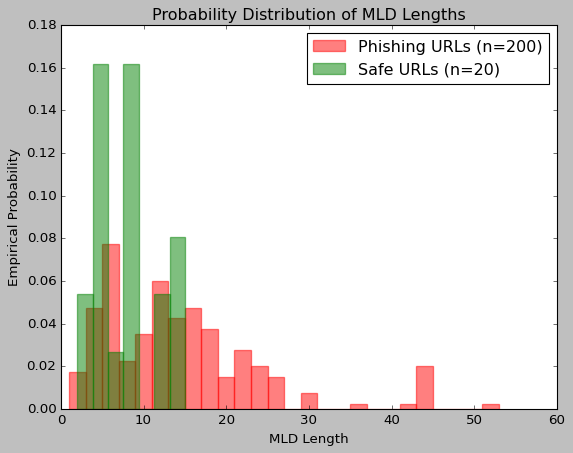

In [195]:
plt.close("all")

def plot_hist(df, description, color, edgecolor):
    # This function returns a pyplot histogram of the mld lengths of the given url dataframe.
    
    wanted_data = df.iloc[5]
    w = 2
    # Number of bins according to bin width (w):
    bins = math.ceil((wanted_data.max() - wanted_data.min())/w)
    # Return histogram:
    return plt.hist(wanted_data,
                    bins,
                    color=color,
                    alpha=0.5,
                    label=description + f' (n={len(wanted_data)})',
                    edgecolor=edgecolor,
                    linewidth=1.2,
                    density=1)

# Plot both bad and good urls:
plot_hist(url_data_bad, 'Phishing URLs', 'r', 'red')
plot_hist(url_data_good, 'Safe URLs', 'g', 'green')

plt.title(f'Probability Distribution of MLD Lengths')
plt.legend(loc='upper right')
plt.ylabel('Empirical Probability')
plt.xlabel('MLD Length')
plt.show()

## #5: Interpretation of Visualization

### 5.1: Findings:
- As can be seen from the above graph, the MLD lengths of "safe" URLs all seem to be around 2-15.
- By contrast, the MLDs of phishing URLs tend to be much longer.
- The distribution of the phishing URLs has a lower kurtosis than the safe URLs, i.e. the variance of the phishing URL MLD lengths is much larger the one of the safe URLs. As expected, the distribution of the MLD lengths of phishing URLs has a long right tail.

### 5.2: Conclusions:
- The MLD lengths of safe URLs tend to be under 20 characters.
- The MLD lengths of phishing URLs can range far beyond 20 characters.
- Therefore, **a URL with a long MLD can be a signal of a malicious phishing site.**


## #6: Limitations

- The sample size for the safe URLs was very small (n=20) and they were hand-picked. Therefore, the sample cannot be treated as a true representation of the whole population of safe URLs.
- It seems that phishing sites reported to phishtank.com tend to be submitted in chunks, which sometimes contain multiple nearly identical URLs. This can skew the results towards certain types of URLs.

## #7 Error Handling

- The only feature which takes use of external information is Alexa ranking. If, for some reason, the top 1 million Alexa Rankings couldn't be fetched, the dataframe containing the Alexa Rankings ('alexa_top_million') is returned **empty** and an error is raised.
- If errors occur in the extracting of other features, it is due to bugs in code, which have to be assessed manually.